In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import z,y,t
import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt


## First will Model a non-linear Pendulem

For generalisation will derive EoM with lagrange method

In [2]:
me.dynamicsymbols('q:3')

[q0(t), q1(t), q2(t)]

In [3]:
m,g,l_m = sym.symbols(['m','g','l_m'])

q = sym.Matrix(me.dynamicsymbols('q:1'))
qd = sym.Matrix(me.dynamicsymbols('q:1',1))
qdd = sym.Matrix(me.dynamicsymbols('q:1',2))

## Lift forces

Assume lift acts from a single point 'l_f' away from the hinge

$L = \frac{1}{2}\rho V^2SC_L\alpha(\theta),\;\;S=s_t*c$

From small angle approximation of my geometrically exact model

$\alpha(\theta) = \alpha_r\cos\theta + \alpha_h \cos\alpha_h,\;\;\alpha_h = \arctan(\sin\Lambda\sin\theta)$

In [4]:
alpha_r,Lambda = sym.symbols(['alpha_r','Lambda'])
rho,s_t,c,C_L,l_f,V,w_g = sym.symbols(['rho','s_t','c','C_L','l_f','V','w_g'])

half = sym.Rational(1,2)
theta_a = q[0]#-sym.pi*half
alpha_h = sym.atan(sym.sin(Lambda)*sym.sin(theta_a))
alpha = alpha_r*sym.cos(theta_a)+alpha_h*sym.cos(alpha_h)
A = sym.Function('A')(q[0])
dL = half *rho * V**2 * s_t*c*C_L*(A-qd[0]*y/V+w_g*sym.cos(theta_a))

alpha_h_func = sym.lambdify((alpha_r,Lambda,q),alpha)
d_alpha_d_theta_func = sym.lambdify((alpha_r,Lambda,q),alpha.diff(q[0]))

L = dL.integrate((y,0,s_t))

Aero_Moment = (dL*y).integrate((y,0,s_t))

#work done by the force is 
W = (dL*y*q[0]).integrate((y,0,s_t))

def V_func(t):
    return 10

def w_g_func(t):
    return 0

fun = sym.lambdify((rho,s_t,c,C_L,l_f,alpha_r,Lambda,V,w_g,q,qd),Aero_Moment)


#fun(1.2,1,0.1,2*np.pi,1,np.pi/180,-np.pi/18,V_func(1),w_g_func(1),[0],[0])
RHS = W.diff(q[0])
me.mechanics_printing()

# sub in terms for alpha_h and its derivative (to be thrown in latter)
a_h,adot_h = sym.symbols(['a_h','adot_h'])
RHS = RHS.subs({A.diff(q[0]):adot_h,A:a_h})


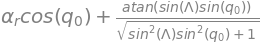

In [5]:
alpha

### Potential Energy

In [6]:
half = sym.Rational(1,2)
U = -m*g*l_m*sym.cos(q[0]+sym.pi*half)
U

### Kinetic Energy

In [7]:
me.mechanics_printing()
# get the transform matrix
Transform = symt.HomogenousTransform().R_x(q[0]).Translate(0,l_m,0)
# get the jacobian of x,y,z positon
J_xyz = Transform.Transform_point([0,0,0]).jacobian(q)
# get jacobian of rotations
J_r = sym.Matrix([q[0],0,0]).jacobian(q)

#get Jacobian
J = sym.Matrix(list(J_xyz) + list(J_r))
J

# create mass matrix of CoM in its frame
M_q = sym.diag(m,m,m,0,0,0)

#calculate the mass Matrix
M = J.T*M_q*J
M.simplify()
M
#calculate the K.E
T = (sym.Rational(1,2)*qd.T*M*qd)[0]
T

### EoM

In [8]:
# make a place holder for external forces
f, = sym.symbols(['f'])
# calculate LHS of Lagranagian Equation
Lag = sym.Matrix([T-U])
term_1 = Lag.jacobian(qd).diff(me.dynamicsymbols._t).T
term_2 = Lag.jacobian(q).T
EoM = term_1-term_2-sym.Matrix([RHS])

# solve for each acceleration term
a_eq = sym.linsolve(list(EoM[:]),list(qdd))

# create funcs
funcs = []
for i in range(0,len(q)):
    funcs.append(sym.lambdify((m,g,l_m,rho,s_t,c,C_L,alpha_r,Lambda,V,w_g,a_h,adot_h,q,qd),a_eq.args[0][0]))

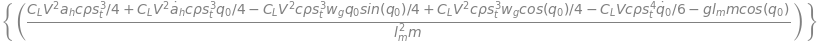

In [9]:
a_eq

### Including external forces

[Text(0, 0.5, 'Hinge Moment'),
 Text(0.5, 0, 't'),
 Text(0.5, 1.0, 'Hinge Moment')]

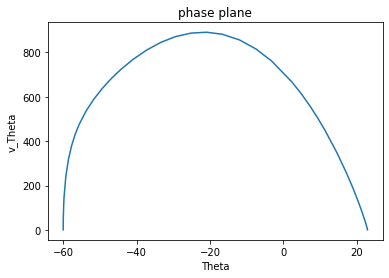

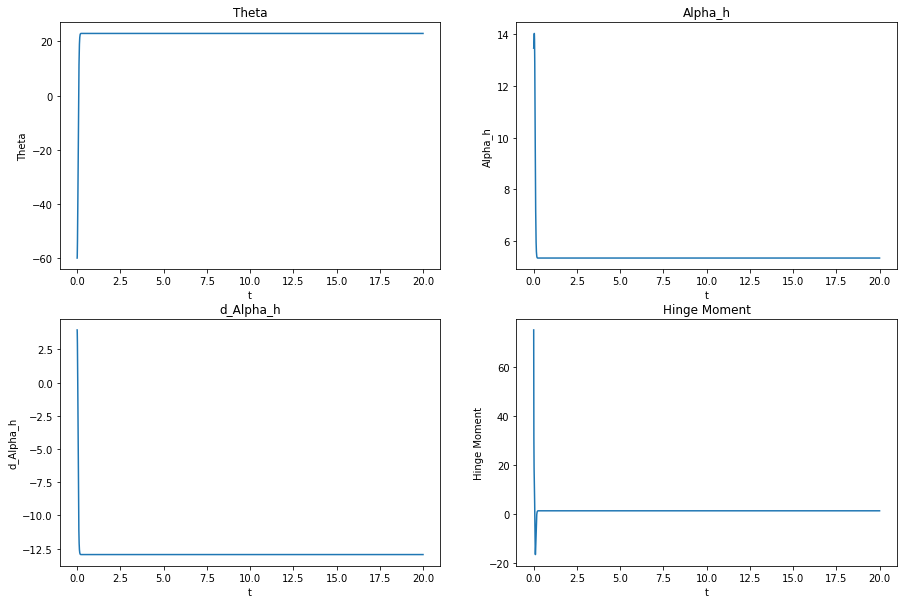

In [214]:
# create single sys func
def deriv(t,y,m,g,l_m,rho,s_t,c,C_L,alpha_r,Lambda,V_fun,W_fun,a_h_fun,adot_h_fun):    
    result = ()    
    for i in range(0,len(q)):
        result = (result + (y[i*2+1],))
        
        v = funcs[i](m,g,l_m,rho,s_t,c,C_L,alpha_r,Lambda,V_fun(t),W_fun(t),a_h_fun(t,y),adot_h_fun(t,y),[y[i*2]],[y[i*2+1]])       
        
        result = (result + (v,))    
    return result

# create ode solution specific function
_m = 0.3
_g = 9.81
_l_m = 0.5
_rho = 1.225
_s_t = 1
_c = 0.15
_C_L = 2*np.pi
_alpha_r = np.deg2rad(10)
_Lambda = np.deg2rad(-10)

def V_func(t):
    v = 40
    #noise = 0#np.sin(t/(2*np.pi*1))*1
    return v#np.clip(v + noise,0,100)
def w_g_func(t):
    return 0 #np.sin(t*100/(2*np.pi))*0.3

def func(t,q,qd):
    damping = 0   
    return 29-qd[0]*2

def Alpha(t,y):
    return alpha_h_func(_alpha_r,_Lambda,[y[0]])

def d_Alpha_d_theta(t,y):
    return d_alpha_d_theta_func(_alpha_r,_Lambda,[y[0]])

def sol_deriv(t,y):
    return deriv(t,y,_m,_g,_l_m,_rho,_s_t,_c,_C_L,_alpha_r,_Lambda,V_func,w_g_func,Alpha,d_Alpha_d_theta)

# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 28, 0.01
ts = np.arange(0, tmax+dt, dt)
# Initial conditions: theta, dtheta/dt, L, dL/dt
y0 = [-np.pi/3, 0]
yData = solve_ivp(sol_deriv,(0,20),y0,method='LSODA',max_step=0.01)

yData.y[0][0]
fig = plt.figure()
ax = plt.plot(np.rad2deg(yData.y[0]),np.rad2deg(yData.y[1]))
plt.title('phase plane')
plt.xlabel('Theta')
plt.ylabel('v_Theta')


fig,axes = plt.subplots(2,2,figsize=(15,10))
alph = [yData.y[0]]
# theta plot
axes[0][0].plot(yData.t,np.rad2deg(yData.y[0]))
axes[0][0].set(title='Theta',ylabel='Theta',xlabel='t')

# alpha plot
axes[0][1].plot(yData.t,np.rad2deg(Alpha(yData.t,[yData.y[0]])))
axes[0][1].set(title='Alpha_h',ylabel='Alpha_h',xlabel='t')

# d_alpha plot
axes[1][0].plot(yData.t,np.rad2deg(d_Alpha_d_theta(yData.t,[yData.y[0]])))
axes[1][0].set(title='d_Alpha_h',ylabel='d_Alpha_h',xlabel='t')

# d_alpha plot
M_func = sym.lambdify((m,g,l_m,rho,s_t,c,C_L,alpha_r,Lambda,V,w_g,a_h,adot_h,q,qd),RHS)
def Hinge_Aero(t,y):
    return M_func(_m,_g,_l_m,_rho,_s_t,_c,_C_L,_alpha_r,_Lambda,V_func(t),w_g_func(t),Alpha(t,y),d_Alpha_d_theta(t,y),[y[0]],[y[1]])

axes[1][1].plot(yData.t,Hinge_Aero(yData.t,yData.y))
axes[1][1].set(title='Hinge Moment',ylabel='Hinge Moment',xlabel='t')



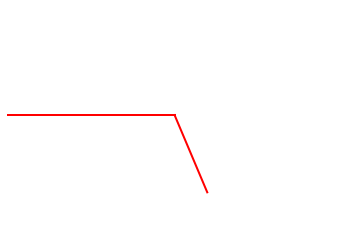

In [215]:
from matplotlib.animation import writers
writers.reset_available_writers()
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
mywriter = animation.FFMpegWriter()
#plt.rcParams['animation.ffmpeg_path'] =r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop\ffmpeg\ffmpeg-20200211-f15007a-win64-static\bin\ffmpeg.exe'
#plt.rcParams['animation.convert_path'] = r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Programs\ImageMagick-7.0.9-22\magick.exe'
#rc('animation', html='html5')

def plot_FWT(theta, d, L,fwt):
    xs = [0,L*np.sin(theta)]
    ys = [d,(d)-(L*np.cos(theta))]
    fwt.set_data(xs,ys)
    
def plot_sys(theta, d, L, ax, r=0.1):
    #plot_spring(np.pi,1)
    plot_FWT(np.pi/2,0,1)
    c0 = Circle((0, d+1), r/2, fc='k', zorder=10)
    ax.add_patch(c0)
    ax.set()

    
fig = plt.figure()
ax = plt.axes(xlim=(-1.5,1.5),ylim=(-0.5,2.5))
ax.axis('equal')
ax.set()
fwt, = ax.plot([], [], 'r-',lw=2)
wing, = ax.plot([], [], 'r-',lw=2)
plot_FWT(-np.pi/2,0+1,3,wing)

# initialization function 
def init(): 
    # creating an empty plot/frame 
    fwt.set_data([], [])          
    return fwt,
                    
def animate(i):
    theta = yData.y[0][i]
    # d = yData[i][2]
    d = 0
    plot_FWT(theta,0+1,1,fwt)
    return fwt,
                    
plt.axis('off')                     
# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(yData.t), interval=20, blit=True)

HTML(anim.to_html5_video())

## Lift forces

Assume lift acts from a single point 'l_f' away from the hinge

$L = \frac{1}{2}\rho V^2SC_L\alpha(\theta),\;\;S=s_t*c$

From small angle approximation of my geometrically exact model

$\alpha(\theta) = \alpha_r\cos\theta + \alpha_h \cos\alpha_h,\;\;\alpha_h = \arctan(\sin\Lambda\sin\theta)$

In [17]:
alpha_r,Lambda = sym.symbols(['alpha_r','Lambda'])
rho,s_t,c,C_L,l_f,V,w_g = sym.symbols(['rho','s_t','c','C_L','l_f','V','w_g'])

alpha_h = sym.atan(sym.sin(Lambda)*sym.sin(q[0]))
alpha = alpha_r*sym.cos(q[0])+alpha_h*sym.cos(alpha_h)
dL = half *rho * V**2 * s_t*c*C_L*(alpha+qd[0]*y/V+w_g*sym.cos(q[0]))
L = dL.integrate((y,0,s_t))

M = (dL*y).integrate((y,0,s_t))


def V_func(t):
    return 10

def w_g_func(t):
    return 0

fun = sym.lambdify((rho,s_t,c,C_L,l_f,alpha_r,Lambda,V,w_g,q,qd),M)


fun(1.2,1,0.1,2*np.pi,1,np.pi/180,-np.pi/18,V_func(1),w_g_func(1),[0],[0])


In [ ]:
Transform = symt.HomogenousTransform().R_x(-sym.pi*sym.Rational(1,2)+q[0]).Translate(0,l_f,0)

In [ ]:
((sym.Matrix([0])
            .jacobian(self.q).T*dL_w)
            .integrate((y,0,self.p.s_t)))

In [ ]:
sym.Matrix([0]).jacobian(q)

In [8]:
f, = me.dynamicsymbols(['f'])

test = f*2
test

In [13]:
def Myf(t):
    return 2*t

a = sym.lambdify((f,t),test)

a(Myf,2)

TypeError: unsupported operand type(s) for *: 'int' and 'function'

In [125]:
[ for i in [0,1,2]]

In [127]:
alpha_h_func(0,0,[[0,1]])

array([0., 0.])